# Multiregion Windpower Model

In [1]:
import datetime as dt
import sys
sys.path.insert(0,'../../../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from rivapy.tools.datetime_grid import DateTimeGrid

from rivapy.models.residual_demand_fwd_model import WindPowerForecastModel, MultiRegionWindForecastModel, ResidualDemandForwardModel


%load_ext autoreload
%autoreload 2
%matplotlib inline

C:\Users\doeltz\development\RiVaPy\docs\source\notebooks\models\../../../..\rivapy\__init__.py:11: UserWarning: The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.
  warnings.warn('The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.')


## Modelsetup

This notebook explains the MultiRegionWindForecastModel class to model the wind in different regions (e.g. for the pricing of greeen PPA). 

For this we assume that we have given $n$ artificial regions...


Let us denote by $q_i(t,T)$ the wind forecast at time $t$ for future time $T$  in region $i$ (as  percentage of maximal capacity for this region) by
$$
q_i(t,T) = E\left[f\left(f^{-1}(q_i(0,T)) + X^i_T-X_0^i\right)\mid X^i_t\right]
$$
where $f$ is an invertible sigmoid function such as the logistic or smoothstep function and $X_t$ a stochastic process. We define $\phi^i(T):= f^{-1}(q_i(0,T))-X^i_0$ and get
$$
q_i(t,T) = E\left[f\left(\phi^i(T) + X^i_T\right)\mid X^i_t\right]
$$

In [2]:
# setup 
wind_region_model = {}
vols = [1.0,3.0,6.0]
mean_reversion_speed = [0.5,2.0,6.0]
capacities = [10_000.0, 120_000.0, 75_000.0]
rnd_weights = [ [0.8,0.2],
               [0.8,0.2],
               [0.8,0.2]
              ]
np.random.seed(42)
regions = []
for i in range(len(vols)):
    model = WindPowerForecastModel(region='Region_' + str(i), 
                                            speed_of_mean_reversion=mean_reversion_speed[i],
                                            volatility=vols[i])
    regions.append(MultiRegionWindForecastModel.Region( 
                                    model,
                                    capacity=capacities[i],
                                    rnd_weights=rnd_weights[i]
                                ) )
wind = MultiRegionWindForecastModel('Wind_Germany', regions)

After setting up three regions we just simulate the weather forecast over the next ten days for the following four hours.

In [3]:
n_sims = 10_000
days = 10 # number of days
timegrid = np.linspace(0.0, days*1.0/365.0, days*24) # simulation time grid
forward_expiries = [timegrid[-1] + i/(365.0*24.0) for i in range(4)] # time points for the forwards
rnd = np.random.normal(size=wind.rnd_shape(n_sims, timegrid.shape[0]))
results = wind.simulate(timegrid, rnd, expiries=forward_expiries, 
                                       initial_forecasts={'Region_0': [0.7, 0.7,0.6,0.5],
                                                          'Region_1': [0.75, 0.6, 0.5, 0.5],
                                                         'Region_2': [0.8, 0.6, 0.5, 0.5]} # initial forecast values for the repsective 4 hours 
                               )

In [4]:
# We get the To obtain the respective simulations we 
results.keys()

{'Region_0_FWD0',
 'Region_0_FWD1',
 'Region_0_FWD2',
 'Region_0_FWD3',
 'Region_1_FWD0',
 'Region_1_FWD1',
 'Region_1_FWD2',
 'Region_1_FWD3',
 'Region_2_FWD0',
 'Region_2_FWD1',
 'Region_2_FWD2',
 'Region_2_FWD3',
 'Wind_Germany_FWD0',
 'Wind_Germany_FWD1',
 'Wind_Germany_FWD2',
 'Wind_Germany_FWD3'}

## Path Simulation

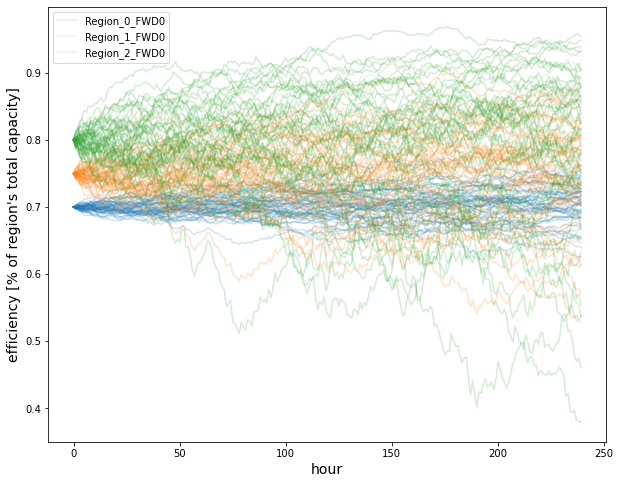

In [68]:
plt.figure(figsize=(10,8))
for k in results.keys():
    if ('Region' in k) and ('FWD0' in k):
        tmp = results.get(k)
        label = k
        p = plt.plot(tmp[:,0],alpha=0.1, label=label)
        for j in range(1,50):
            label = None
            plt.plot(tmp[:,j],color = p[0].get_color(), alpha=0.2, label=label)
plt.legend()
plt.xlabel('hour', fontsize=14)
plt.ylabel("efficiency [% of region's total capacity]", fontsize=14);
#plt.savefig('wind_efficiency_simulated.png', dpi=400)

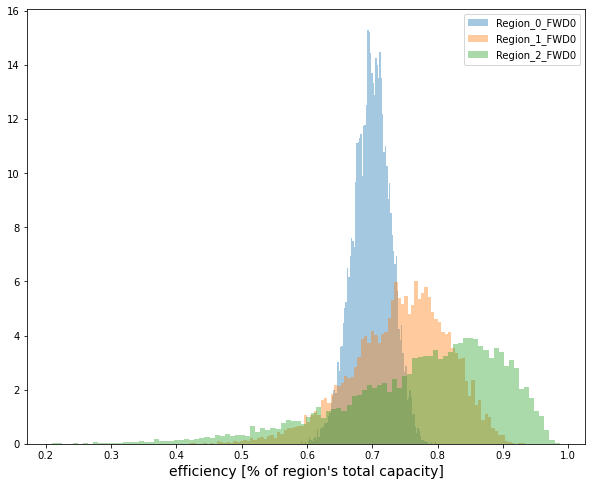

In [65]:
plt.figure(figsize=(10,8))
for k in results.keys():
    if ('Region' in k) and ('FWD0' in k):
        tmp = results.get(k)
        plt.hist(tmp[-1,:],bins = 100, alpha=0.4, label=k, density = True)
plt.legend()
#plt.xlabel('hour')
plt.xlabel("efficiency [% of region's total capacity]", fontsize=14);
#plt.savefig('wind_efficiency_dist.png', dpi=400)

The following code cell contains just a snippet to demonstrate how easy one may use geopandas to visualize spatial data (here the wind speed). It is just for demonstration purposes and is in no way meaningful. Follow the instructiosn in the corresponding file to make the next cell run.

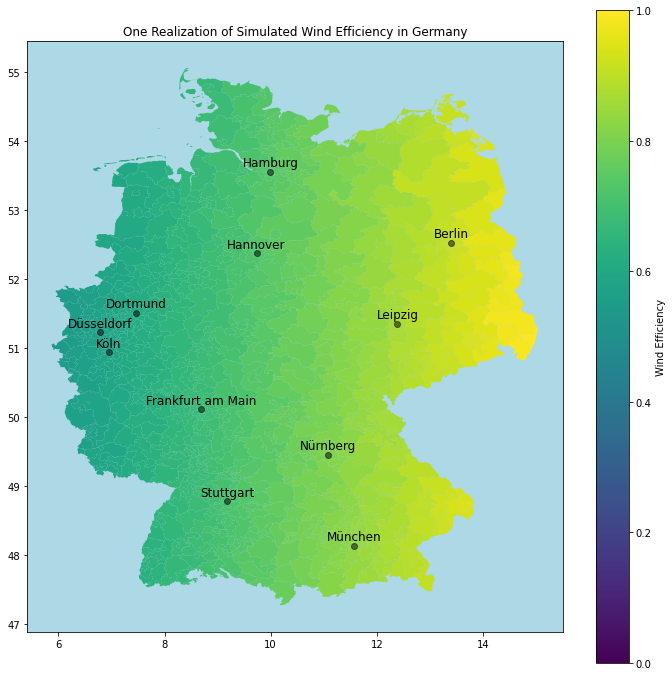

In [57]:
from geopandas_residual_demand_forward_model import plot_efficiency_map
plt.figure(figsize=(12,12))
plot_efficiency_map(results)
#plt.savefig('wind_efficiency_map.png', dpi=400)